
*   Использовать фотографии 3х людей (по 50 каждого);
*   Обучить нейронку так, чтобы она хорошо классифицировала новые фотографии.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 7.3MB/s 


Импортируем библиотеки.

In [ ]:
import mtcnn
print(mtcnn.__version__)
'%tensorflow_version 1.x'
import numpy as np
import matplotlib.pyplot as pyplot
from mtcnn.mtcnn import MTCNN as MTCNN
import cv2
from google.colab import drive
from PIL import Image
%matplotlib inline

0.1.0


Рассмотрим работу mtcnn.

Функция возвращает массив-лицо и преобразует его к заданному размеру, если resize == True
  Параметры:
filename -- строка - путь к файлу с исходным изображением
required_size -- кортеж из двух целых чисел - размер финального изображения
resize -- boolean, который определяет, нужно ли менять размер изображения
  Возвращает np.ndarray, в котором записано обрезанное изображение с найденным на первоначальной картинке лицом.

In [ ]:
def extract_face(fileName, required_size=(224,224), resize=True):
    #pixels = pyplot.imread(fileName)
    print("extract_face::fileName:" + fileName)
    pixels = cv2.cvtColor(cv2.imread(fileName), cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    if resize:
        image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def print_image(img):
    if isinstance(img, str):
        img = pyplot.imread(img)
    pyplot.imshow(img)
    pyplot.show()

Последняя функция выводит изображение на экран.

Выводим фотографию.

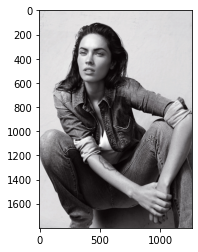

In [ ]:
pathToCheckImg = "/content/drive/My Drive/data/fox/2.jpg"
print_image(pathToCheckImg)

Детектируем лицо.

extract_face::fileName:/content/drive/My Drive/data/fox/2.jpg


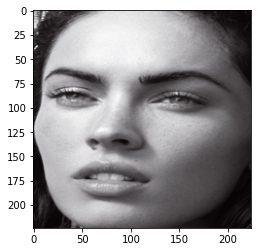

In [ ]:
print_image(extract_face(pathToCheckImg))

Реализуем VGGFace в классах keras. VGGFace - архитектура, заточенная для задачи распознавания лиц.

In [ ]:
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

Т.к. уже существуют оптимальные веса для задачи распознавания лиц, скачаем их: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view.

Теперь загрузим веса и зафиксируем их (т.е. сделаем так, чтобы при дообучении они не изменялись).

In [ ]:
from keras.models import model_from_json
weightPath = "/content/drive/My Drive/vgg_face_weights.h5"
model.load_weights(weightPath)

In [ ]:
from keras import Model

final_layer = Dense(2, activation="softmax") (model.layers[-2].output)

model = Model(model.inputs, final_layer)
for layer in model.layers[:-1]:
    layer.trainable = False

Компилируем нейросеть.

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0   

Незамороженными осталось 5246 параметров на добавленном слое, которые нами и нужно подобрать для классификации

Запишем в переменные files 1/2/3/4 списки файлов изображений.

In [ ]:
import os
dir1 = "/content/drive/My Drive/data/fox"
dir2 = "/content/drive/My Drive/data/johansson"
dir3= "/content/drive/My Drive/test/foxx"
dir4= "/content/drive/My Drive/test/jo"

files1 = os.listdir(dir1)
files2 = os.listdir(dir2)
files3 = os.listdir(dir3)
files4 = os.listdir(dir4)

files1 = [file for file in files1 if  ".jpg" in file]
files2 = [file for file in files2 if  ".jpg" in file]
files3 = [file for file in files3 if  ".jpg" in file]
files4 = [file for file in files4 if  ".jpg" in file]

print(files1)

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '12.jpg', '13.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '49.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '50.jpg']


Проводим детектирование лиц на каждой картинке.

In [ ]:
images1 = [extract_face(os.path.join(dir1,i), resize=True) for i in files1]
images2 = [extract_face(os.path.join(dir2,i), resize=True) for i in files2]
images3 = [extract_face(os.path.join(dir3,i), resize=True) for i in files3]
images4 = [extract_face(os.path.join(dir4,i), resize=True) for i in files4]

extract_face::fileName:/content/drive/My Drive/data/fox/1.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/2.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/3.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/4.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/5.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/6.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/7.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/8.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/9.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/10.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/12.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/13.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/15.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/16.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/17.jpg
extract_face::fileName:/content/drive/My Drive/data/fox/18.jpg
e

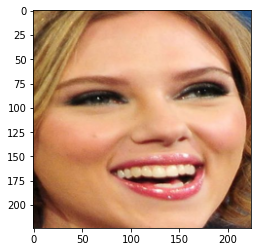

In [ ]:
print_image(images2[10])

Сформируем тренировочную и тестовую выборки.

In [ ]:
X_train  = images1[:-10] + images2[:-10]
y_train = [[1,0]] * len(images1[:-10]) + [[0,1]] * len(images2[:-10])

X_test =  images1[-10:] + images2[-10:]+images3[:] + images4[:] 
y_test = [[1,0]] * len(images1[-10:])+[1,0] +[1,0] +[1,0] + [[0,1]] * len(images2[-10:])+ [0,1]+ [0,1]+[0,1]

Проведем аугментацию тренировочной выборки.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow(np.asarray(X_train), np.asarray(y_train))

Обучаем нейросеть.

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16027577675136754400
]


In [ ]:
%%time
model.fit_generator(train, epochs=50, verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
3/3 - 39s - loss: 0.6822 - accuracy: 0.8784
Epoch 2/50
3/3 - 37s - loss: 0.6627 - accuracy: 0.9730
Epoch 3/50
3/3 - 38s - loss: 0.6432 - accuracy: 0.9865
Epoch 4/50
3/3 - 38s - loss: 0.6186 - accuracy: 0.9865
Epoch 5/50
3/3 - 38s - loss: 0.5946 - accuracy: 1.0000
Epoch 6/50
3/3 - 41s - loss: 0.5739 - accuracy: 1.0000
Epoch 7/50
3/3 - 38s - loss: 0.5551 - accuracy: 0.9865
Epoch 8/50
3/3 - 38s - loss: 0.5375 - accuracy: 0.9865
Epoch 9/50
3/3 - 37s - loss: 0.5217 - accuracy: 1.0000
Epoch 10/50
3/3 - 37s - loss: 0.5024 - accuracy: 1.0000
Epoch 11/50
3/3 - 37s - loss: 0.4834 - accuracy: 0.9865
Epoch 12/50
3/3 - 37s - loss: 0.4632 - accuracy: 0.9865
Epoch 13/50
3/3 - 37s - loss: 0.4540 - accuracy: 1.0000
Epoch 14/50
3/3 - 37s - loss: 0.4399 - accuracy: 1.0000
Epoch 15/50
3/3 - 37s - loss: 0.4230 - accuracy: 1.0000
Epoch 16/50
3/3 - 37s - loss: 0.4182 - accuracy: 1.0000
Epoch 17/50
3/3 - 37s - loss: 0.4002 - accuracy: 1.0000
Epoch 18/50
3/3 - 37s - loss: 0.3988 - accuracy: 1.0000
E

Сохраним веса.

In [ ]:
model.save_weights("/content/drive/My Drive/lab_weights.h5")

In [ ]:
model.load_weights("/content/drive/My Drive/lab_weights.h5")

Посмотрим на предсказания модели на тестовых данных.

In [ ]:
model.predict(np.asarray(X_test))

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [9.9999976e-01, 1.9232483e-07],
       [0.0000000e+00, 1.

Для Меган Фокс - [1 0], для Скарлетт Йоханссон - [0 1].

Примеры.

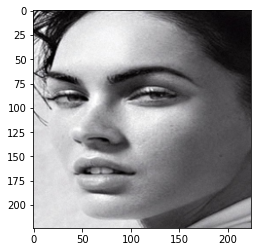

In [ ]:
pyplot.imshow(Image.fromarray(X_test[1]))

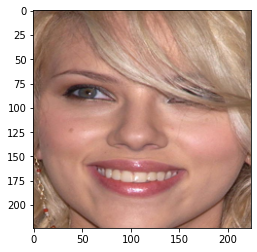

In [ ]:
pyplot.imshow(Image.fromarray(X_test[11]))

Проверим модель на новых, более сложных фотографиях.

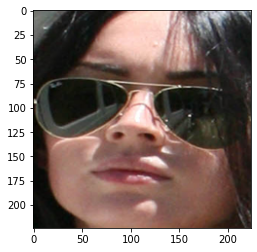

In [ ]:
pyplot.imshow(Image.fromarray(X_test[21]))

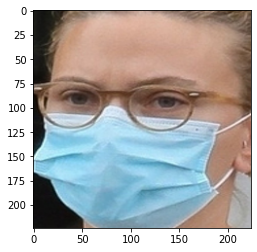

In [ ]:
pyplot.imshow(Image.fromarray(X_test[25]))

Проверим ошибочное фото.

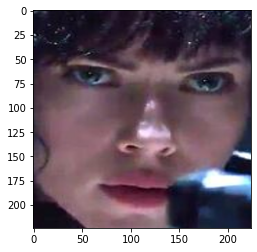

In [ ]:
pyplot.imshow(Image.fromarray(X_test[24]))

Лицо детектируется, но Скарлетт, к сожалению, определить не удалось.

Проверим модель на постороннем человеке.

In [ ]:
test="/content/drive/My Drive/data/bellucci"
test_bel = os.listdir(test)

test_bel = [file for file in test_bel if  ".jpg" in file ]

images_test_bel = [extract_face(os.path.join(test,i), resize=True) for i in test_bel]

In [ ]:
model.predict(np.asarray(images_test_johansson))

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 9.4972247e-30],
       [1.0000000e+00, 5.7797353e-35],
       [1.0000000e+00, 0.0000000e+00],
       [1.5389124e-23, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [2.8445329e-11, 1.0000000e+00],
       [9.5226637e-13, 1.0000000e+00],
       [1.0000000e+00, 6.1532597e-31],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 5.4055881e-19],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 7.3592958e-30],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [5.6137984e-30, 1.0000000e+00],
       [1.0000000e+00, 1.4725040e-35],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.0442528e-36],
       [1.0000000e+00, 0.

Как видно из массива значений, модель рандомно определяет стороннего человека, как одного из известных. 